# Check metrics

In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
from matplotlib.colors import Normalize
import pandas as pd
import numpy as np
from astropy.io import fits
from astropy.constants import c, e, m_e
import astropy.units as u
from sklearn.metrics import root_mean_squared_error as rmse
from scipy.stats import pearsonr
import torch
import sys
sys.path.append('../')
from modules.nn_models import InversionModel
from modules.data_utils import load_data_cubes
from modules.train_test_utils import *

In [2]:
images_path = Path("../thesis_images/fifth_experiment")
if not images_path.exists():
    images_path.mkdir(parents=True)

In [3]:
plt.rcParams.update({
  'axes.titlesize': 'x-large',  # heading 1
  'axes.labelsize': 'large',   # heading 2
  'xtick.labelsize': 'medium',         # fontsize of the ticks
  'ytick.labelsize': 'medium',         # fontsize of the ticks
  'font.family': 'serif',        # Font family
  'text.usetex': False,          # Do not use LaTeX for text rendering
  'figure.figsize': (10, 8),     # Default figure size
  'savefig.dpi': 300,            # High resolution for saving figures
  'savefig.format': 'png',       # Default format for saving figures
  'legend.fontsize': 'medium',  # Font size for legends
  'lines.linewidth': 2,          # Line width for plots
  'lines.markersize': 8,         # Marker size for plots,
  'axes.formatter.useoffset': False,  # Disable offset
  'axes.formatter.use_mathtext': True,  # Use scientific notation
  'axes.formatter.limits': (-3, 4),  # Use scientific notation for values over 10^2
  'axes.labelsize': 'large',     # Font size for axes labels
  'figure.titlesize': 'xx-large', # Font size for suptitles (heading 1)
  'axes.formatter.use_locale': False  # Do not use locale settings
})

## 1. Upload validation data

Tensors stored in: cuda
new_logtau: [-2.00000000e+00 -1.90000000e+00 -1.80000000e+00 -1.70000000e+00
 -1.60000000e+00 -1.50000000e+00 -1.40000000e+00 -1.30000000e+00
 -1.20000000e+00 -1.10000000e+00 -1.00000000e+00 -9.00000000e-01
 -8.00000000e-01 -7.00000000e-01 -6.00000000e-01 -5.00000000e-01
 -4.00000000e-01 -3.00000000e-01 -2.00000000e-01 -1.00000000e-01
  1.77635684e-15]

                ######################## 
                Reading 087000 MuRAM data...
                ######################## 
                      
Charging temperature ...
Charge velocity...
Charging magnetic field vector...

                ######################## 
                Finished!
                ######################## 
                      
Creating atmosphere quantities array...
Saved image to: images/atmosphere/087000_atm_quantities.pdf
Created!
Charging stokes vectors...
Charged!
Keeping only the LOS component of the magnetic field...
atm_quant shape: (480, 480, 256, 4)
Loading optical dep

100%|██████████| 480/480 [00:06<00:00, 69.09it/s]


Loaded!
Spatially convolving the Stokes parameters...


100%|██████████| 300/300 [00:02<00:00, 124.28it/s]


Spectrally convolving the Stokes parameters...


100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


Interpolating Stokes parameters to Hinode/SP wavelengths...


100%|██████████| 4/4 [00:27<00:00,  6.91s/it]


atm surface pixel sampling...


100%|██████████| 4/4 [00:00<00:00, 20.67it/s]


stokes surface pixel sampling...


100%|██████████| 4/4 [00:00<00:00,  8.59it/s]


surface pixel sampling done!
atm shape: (103, 103, 21, 4)
stokes shape: (103, 103, 112, 4)
Scaling the quantities...
Normalizing the Stokes parameters by the continuum...
calculating the continuum...
Scaled!


100%|██████████| 103/103 [00:00<00:00, 383.19it/s]


Saved image to: images/fifth_experiment/stokes/087000_stokes_with_noise.pdf


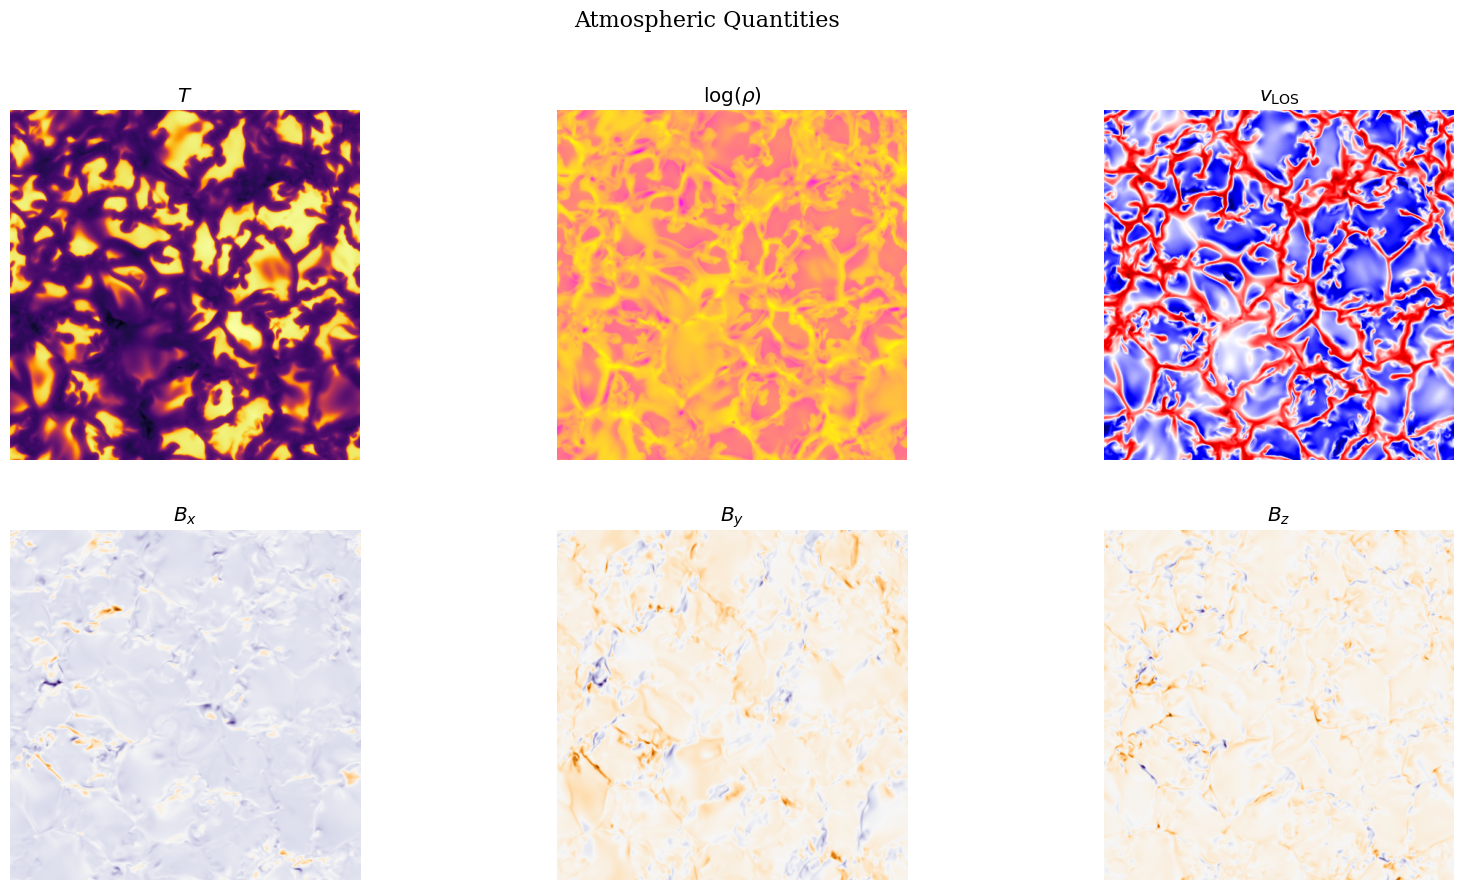

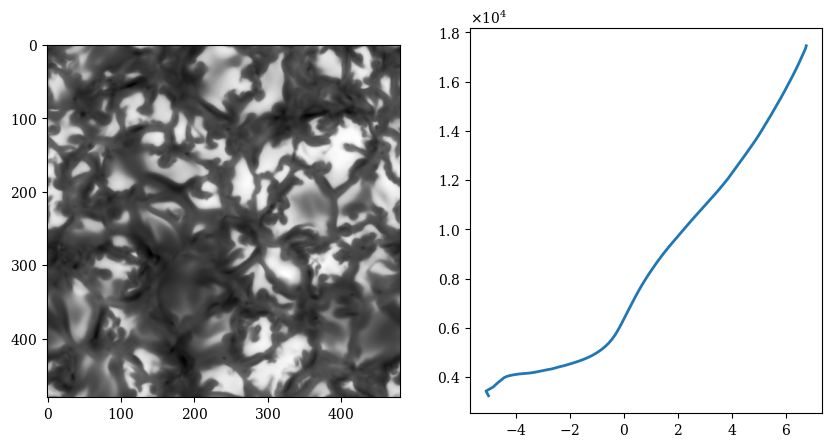

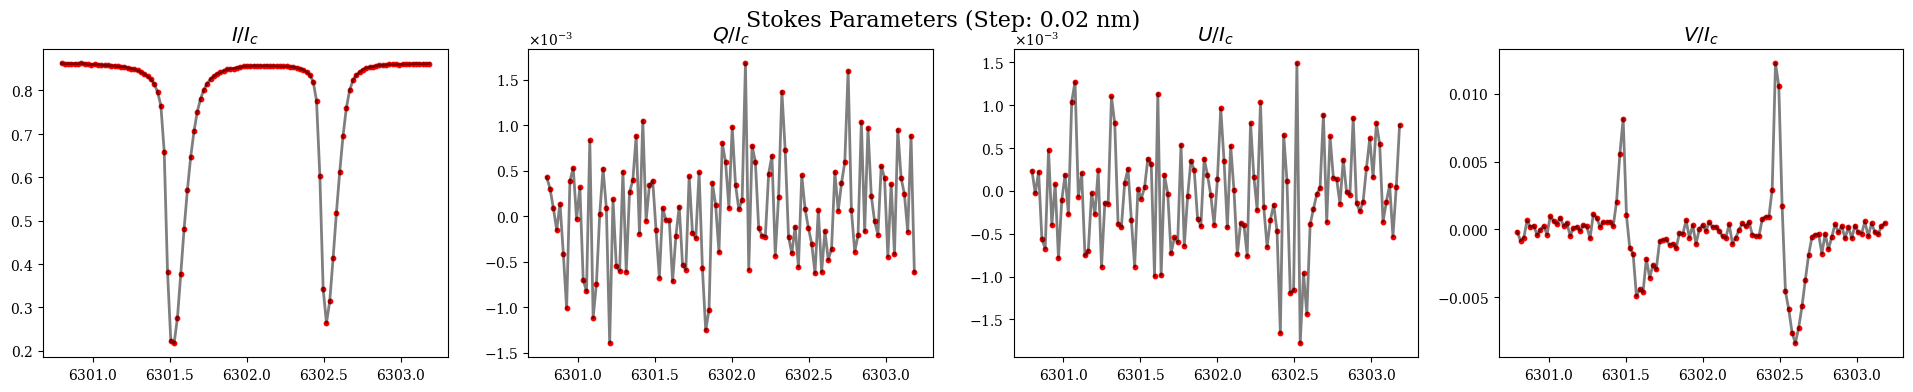

In [4]:
filenames = [
                "087000"
                ]

#########################################################################################
# Models and weights paths
#########################################################################################

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Tensors stored in: {device}")

# Weights paths
#########################################################################################
# Generation
#########################################################################################
nx = 480
ny = 480
noise_level = 5.9e-4 #Hinode noise level (2016 - A. Lagg)
new_logtau = np.arange(-2.0, 0+0.1, 0.1)
stokes_weights = [1,100,100,10]

# Load data
atm_data, stokes_data, mags_names, phys_maxmin, new_nx, new_ny = load_data_cubes(filenames, 
                                                                    ptm = "/scratchsan/observatorio/juagudeloo/data",
                                                                    noise_level=noise_level,
                                                                    new_logtau=new_logtau,
                                                                    stokes_weights=stokes_weights)
for i, filename in enumerate(filenames):
    # Descale atm data
    atm_data_original_muram = np.reshape(np.copy(atm_data[i]), (new_nx, new_ny, new_logtau.shape[0],4))
    atm_data_original_muram = descale_atm(atm_data_original_muram, phys_maxmin)
    atm_data_original_muram[..., 2] /= 1e5
    
    # Load model and charge corresponding stokes data
    stokes_data_original_muram =  np.reshape(np.copy(stokes_data[i]), (stokes_data[i].shape[0]*stokes_data[i].shape[1], stokes_data[i].shape[2],stokes_data[i].shape[3]))
    stokes_data_original_muram = np.moveaxis(stokes_data_original_muram, 1, 2)

## 2. Loss metrics

For this analysis, we will analyze all the loss metrics in the same dataframe to check their overall behaviour.

In [5]:
wfa_weigths = [0,1e-3, 1e-2, 0.1, 0.5]

dataframes_path = Path("../csv/fifth_experiment/")

# Load dataframes
losses_df = {}
for wfa_weight in wfa_weigths:
    losses_df[wfa_weight] = pd.read_csv(dataframes_path / f"Hinode_only_LOS_WFA_constraint_wfa_weight_{wfa_weight}_base_loss_threshold_0.0004_epochs_40" / "loss_metrics.csv")

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(4*3, 3.5))
axs = ax.flatten()
loss_metrics = losses_df[0].columns[:3]
metrics_titles = ["Total loss", "MSE loss", "WFA loss"]
for i, wfa_weight in enumerate(wfa_weigths):
    for j, metric in enumerate(loss_metrics):
        # Plot RMSE
        axs[j].plot(losses_df[wfa_weight].index + 1, losses_df[wfa_weight][metric], label=r"$w=$"+f"{wfa_weight}", color="C"+str(i))
        axs[j].set_title(metrics_titles[j])
        axs[j].set_xlabel("Epochs")
        axs[j].set_ylabel("MSE")
        axs[j].legend()
        axs[j].grid()
        if metric not in ["train_wfa_loss", "test_wfa_loss"]:
            axs[j].set_yscale("log")
            axs[j].set_ylim(1e-4, 1e-2)
        axs[j].set_xlim(1, 40)
fig.subplots_adjust(hspace=0.4, wspace=0.4)
plt.tight_layout()
fig.savefig(images_path / "Hinode_only_LOS_WFA_constraint_loss_metrics.png", dpi=300, bbox_inches="tight")
plt.show()

## 3. RMSE and correlation

In [7]:
def measure_time(func, *args, **kwargs):
    """
    Measures the time taken by a function to execute.

    Args:
        func (callable): The function to time.
        *args: Positional arguments for func.
        **kwargs: Keyword arguments for func.

    Returns:
        tuple: A tuple containing the result of func and the elapsed time in seconds.
    """
    start = timer()
    result = func(*args, **kwargs)
    end = timer()
    elapsed = end - start
    print(f"Elapsed time: {elapsed:.4f} seconds")
    return result, elapsed

### 3.1 Without WFA constraint

In [8]:
atm_generated_not_WFA_muram = {}

target_dir = Path("../models/fifth_experiment")
wfa_weight = 0
for epochs in [20,40]:
    #2. Create models
    scales = [1,2,4]
    los_model = InversionModel(scales=scales, 
                        nwl_points=stokes_data_original_muram.shape[-1],
                        n_outputs=atm_data_original_muram.shape[-1]*len(new_logtau)).to(device).float()
    los_model.name = "only_LOS"

    base_loss_threshold = 0.0004  # Threshold for base loss (in Gauss)
    experiment_name = f"Hinode_"+los_model.name+"_WFA_constraint"+f"_wfa_weight_{wfa_weight}_base_loss_threshold_{base_loss_threshold}_epochs_{epochs}"
    weights_name = f"{experiment_name}.pth"

    print(f"Charging weights from {experiment_name}...")
    charge_weights(model = los_model,
                    target_dir = target_dir,
                    weights_name = weights_name
                )
    
    #Generate results
    print(f"Generating results for {experiment_name}...")
    atm_generated_not_WFA_muram[f"{epochs} epochs"], _ = measure_time(generate_results, model = los_model,
                                    stokes_data = stokes_data_original_muram,
                                    atm_shape=(new_nx,new_ny,new_logtau.shape[0],atm_data_original_muram.shape[-1]),
                                    maxmin = phys_maxmin,
                                    type_of_quantity=1,
                                    device = device
                                    )      
    
    atm_generated_not_WFA_muram[f"{epochs} epochs"][..., 2] /= 1e5

Charging weights from Hinode_only_LOS_WFA_constraint_wfa_weight_0_base_loss_threshold_0.0004_epochs_20...
[INFO] Loading model from: ../models/fifth_experiment/Hinode_only_LOS_WFA_constraint_wfa_weight_0_base_loss_threshold_0.0004_epochs_20.pth
Generating results for Hinode_only_LOS_WFA_constraint_wfa_weight_0_base_loss_threshold_0.0004_epochs_20...
stokes data shape for generation: torch.Size([10609, 4, 112])
atm generated data shape : (103, 103, 21, 4)
Elapsed time: 3.9353 seconds
Charging weights from Hinode_only_LOS_WFA_constraint_wfa_weight_0_base_loss_threshold_0.0004_epochs_40...
[INFO] Loading model from: ../models/fifth_experiment/Hinode_only_LOS_WFA_constraint_wfa_weight_0_base_loss_threshold_0.0004_epochs_40.pth
Generating results for Hinode_only_LOS_WFA_constraint_wfa_weight_0_base_loss_threshold_0.0004_epochs_40...
stokes data shape for generation: torch.Size([10609, 4, 112])
atm generated data shape : (103, 103, 21, 4)
Elapsed time: 0.0974 seconds


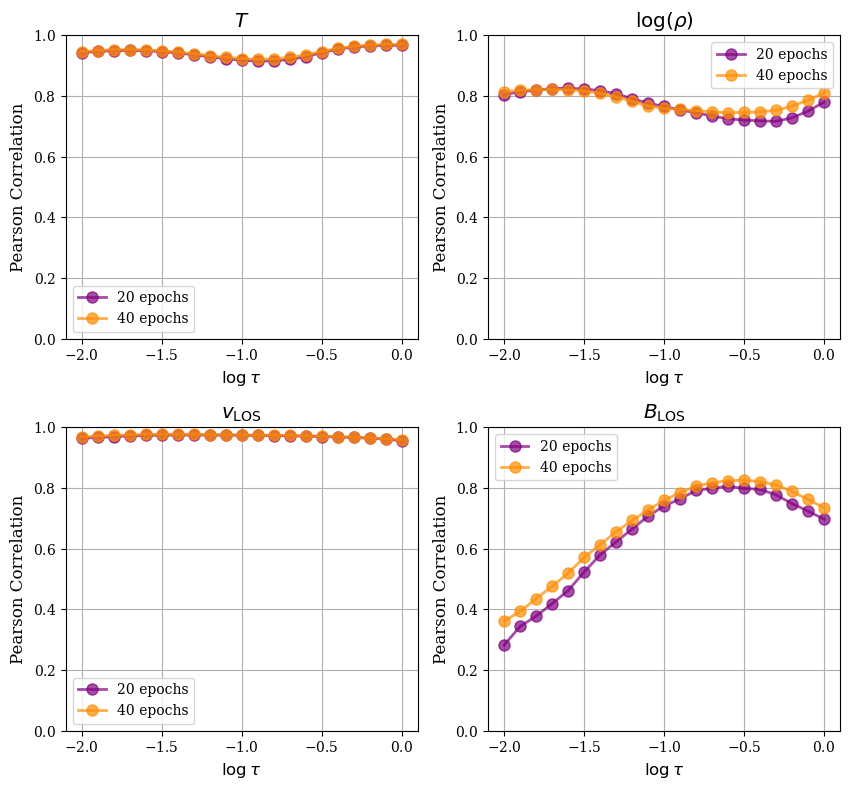

In [9]:
num_params = 4
tau = np.arange(-2.0, 0+0.1, 0.1)

correlations = {}
for key in atm_generated_not_WFA_muram.keys():
    correlations[key] = np.zeros((len(tau), num_params))
    for i, tau_value in enumerate(tau):
        for j in range(num_params):
            gen_values = atm_generated_not_WFA_muram[key][:, :, i, j].flatten()
            orig_values = atm_data_original_muram[:, :, i, j].flatten()
            correlations[key][i, j] = pearsonr(gen_values, orig_values)[0]

fig, axs = plt.subplots(2, 2, figsize=(4.3*2, 4*2))
axs = axs.flatten()  # Flatten to make indexing easier
titles = [r"$T$", r"$\log(\rho)$", r"$v_{\text{LOS}}$", r"$B_\text{LOS}$"]
colors = ["purple", "darkorange"]

for i, key in enumerate(correlations.keys()):
    correlation_data = correlations[key]
    for j in range(num_params):
        axs[j].plot(tau, correlation_data[:, j], marker='o', label=key, alpha = 0.7, color=colors[i])
        axs[j].set_title(titles[j])
        axs[j].set_xlabel(r'$\log \tau$')
        axs[j].set_ylabel('Pearson Correlation')
        axs[j].grid(True)
        axs[j].set_ylim(0, 1)
        axs[j].legend()

plt.tight_layout()
fig.savefig(images_path / f"MURaM_correlation_{filenames[0]}_epochs.png", dpi=300)
plt.show()

In [10]:
num_params = 4
tau = np.arange(-2.0, 0+0.1, 0.1)

# Calculate RMSE instead of correlation
rmse_values = {}
for key in atm_generated_not_WFA_muram.keys():
    rmse_values[key] = np.zeros((len(tau), num_params))
    for i, tau_value in enumerate(tau):
        for j in range(num_params):
            gen_values = atm_generated_not_WFA_muram[key][:, :, i, j].flatten()
            orig_values = atm_data_original_muram[:, :, i, j].flatten()
            rmse_values[key][i, j] = rmse(gen_values, orig_values)

# Create similar plot but for RMSE
fig, axs = plt.subplots(2, 2, figsize=(4.5*2, 4*2))
axs = axs.flatten()  # Flatten to make indexing easier
units = ['K', r'g/cm$^3$', 'km/s', 'G']

for i, key in enumerate(rmse_values.keys()):
    rmse_data = rmse_values[key]
    for j in range(num_params):
        axs[j].plot(tau, rmse_data[:, j], marker='o', label=key, alpha=0.7, color=colors[i])
        axs[j].set_title(titles[j])
        axs[j].set_xlabel(r'$\log \tau$')
        axs[j].set_ylabel(f'RMSE ({units[j]})')
        axs[j].grid(True)
        axs[j].set_ylim(0, np.max(rmse_data[:, j]) * 1.1)  # Set y-axis limits to [0, max_rmse * 1.1]
        # Not setting ylim here as RMSE values can vary widely
        axs[j].legend()

plt.tight_layout()
fig.savefig(images_path / f"MURaM_rmse_{filenames[0]}_epochs.png", dpi=300)
plt.show()

### 3.2 With WFA constraint

Let's define the WFA inversion function that follows the fit of the overdetermined problem
\begin{equation}
    V \approx -\frac{e}{4\pi m_e c} \cdot \lambda_0^2 \cdot g_{\lambda_0} \cdot B_{\text{LOS}} \frac{dI}{dl}
\end{equation}

In [11]:
def B_LOS_from_stokes(stokes:np.ndarray,
                      ll:np.ndarray,
                      start_ll:int,
                      end_ll:int,
                      llambda0:float,
                      g:float,
                      stokes_v_index:int):
    """
    Estimate the line-of-sight magnetic field from a data cube of Stokes I profiles.
    Args:
    stokes: numpy.ndarray
        3D data cube of Stokes I profiles
    ll: numpy.ndarray
        Wavelength axis in amstrongs
    start_ll: int
        Index of the starting wavelength range
    end_ll: int
        Index of the ending wavelength range
    llambda0: float
        Rest wavelength in amstrongs
    g: float
        Landé factor
    stokes_v_index: int
        Index of the Stokes V profile in the data cube
    Returns:
    numpy.ndarray
        2D map of the line-of-sight magnetic field in Gauss
    """
    wfa_constant = e.si / (4 * np.pi) / m_e / c
    wfa_constant = wfa_constant.to(1 / u.G / u.Angstrom )
    def estimate_B(dI_dl, V):
        ND = len(V)
        a = np.zeros([ND, 2])
        a[:, 0] = dI_dl[:]
        a[:, 1] = 1.0
        b = V[:]

        # Correct least-squares solution
        p = np.linalg.pinv(a) @ b / dI_dl.unit
        
        # Compute B_LOS
        B = -p[0]*u.Angstrom / (wfa_constant * (llambda0)**2.0 * g)
        return B
        
    NX = stokes.shape[0]
    NY = stokes.shape[1]

    B = np.zeros([NX,NY])

    for i in range (0,NX):
        for j in range(0,NY):
            dI_dl =  np.gradient(stokes[i,j,0,start_ll:end_ll]) / np.gradient(ll[start_ll:end_ll])
            local_B = estimate_B(dI_dl = dI_dl,
                                V = stokes[i,j,stokes_v_index,start_ll:end_ll])
            B[i,j] = local_B.value
    B = B * u.G
    
    return B

We will show that the last three layers used for the WFA inversion are the most closest ones to the WFA approximation than the first three, by taking their mean values.

In [12]:
top_layers_B_lOS = atm_data_original_muram[..., 0:3, 3].mean(axis=2)
bottom_layers_B_lOS = atm_data_original_muram[..., -4:-1, 3].mean(axis=2)
top_layers_B_lOS.shape, bottom_layers_B_lOS.shape

((103, 103), (103, 103))

Let's check that for the WFA we are taking correctly the FeI $6301.5\,\text{\AA}$ absorption line

In [13]:
nicole_wl = np.linspace(0,300,300)*0.01 + 6300.5
nicole_wl *= u.Angstrom
stokes_muram_visualization = np.reshape(stokes_data_original_muram, (103,103,stokes_data_original_muram.shape[1],stokes_data_original_muram.shape[2]))
muram_continuum = stokes_muram_visualization[:, :, 0, :10].mean(axis = -1)

In [14]:
nicole_start_wl = 15
nicole_end_wl = 50
muram_pixel_y = 80
muram_pixel_x = 80

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(6*3, 3.5), gridspec_kw={'width_ratios': [1, 2, 2]})
# Set title for the entire figure

# Ensure non-scientific notation for x-axis ticks
for a in ax:
    a.ticklabel_format(useOffset=False, style='plain', axis='x')
    # Add some padding for the suptitle
    plt.subplots_adjust(top=0.5)

    # First subplot to show the pixel location on continuum image
    ax[0].imshow(muram_continuum, cmap='gray')
    ax[0].plot(muram_pixel_x, muram_pixel_y, 'r+', markersize=10)  # Mark the pixel position with a red cross
    ax[0].set_title('Continuum with pixel location')
    ax[0].set_xticks([])
    ax[0].set_yticks([])

    # Stokes I plotñ
    ax[1].plot(nicole_wl[nicole_start_wl:nicole_end_wl], stokes_muram_visualization[muram_pixel_y, muram_pixel_x,0,nicole_start_wl:nicole_end_wl], color = "black")
    ax[1].set_xlabel('Wavelength [nm]')
    ax[1].set_ylabel('Intensity [arb. units]')
    ax[1].set_title('Stokes I')

    # Stokes V plot
    ax[2].plot(nicole_wl[nicole_start_wl:nicole_end_wl], stokes_muram_visualization[muram_pixel_y, muram_pixel_x,3,nicole_start_wl:nicole_end_wl], color = "black")
    ax[2].set_xlabel('Wavelength [nm]')
    ax[2].set_ylabel('Intensity [arb. units]')
    ax[2].set_title('Stokes V')

    ax[1].set_xlim(nicole_wl.value[nicole_start_wl], nicole_wl.value[nicole_end_wl])
    ax[2].set_xlim(nicole_wl.value[nicole_start_wl], nicole_wl.value[nicole_end_wl])
plt.tight_layout()
plt.show()

In [16]:
muram_wfa_B_lOS = B_LOS_from_stokes(stokes = stokes_muram_visualization, 
                                   ll = nicole_wl, 
                                   start_ll = nicole_start_wl, 
                                   end_ll = nicole_end_wl, 
                                   llambda0 = 6301.5*u.Angstrom, 
                                   g = 1.67,
                                   stokes_v_index = 3)

Then, plotting the three results with the corresponding RMSE and correlation metrics

In [17]:
import numpy as np
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics import root_mean_squared_error as rmse
from scipy.stats import pearsonr

import matplotlib.pyplot as plt

# Calculate the 5th and 95th percentiles of the WFA data for colorbar limits
vmin = np.percentile(muram_wfa_B_lOS.value, 5)
vmax = np.percentile(muram_wfa_B_lOS.value, 95)

# Make the colorbar symmetric around zero if needed
if abs(vmin) > abs(vmax):
    vmax = abs(vmin)
else:
    vmin = -abs(vmax)

# Calculate RMSE and correlation metrics
rmse_last_layers = rmse(muram_wfa_B_lOS.value.flatten(), top_layers_B_lOS.flatten())
rmse_first_layers = rmse(muram_wfa_B_lOS.value.flatten(), bottom_layers_B_lOS.flatten())

# Create figure with constrained_layout instead
fig, axes = plt.subplots(1, 3, figsize=(10.5, 3.5), constrained_layout=True)

# Create a common normalization for all plots
norm = Normalize(vmin=vmin, vmax=vmax)
# Plot the three images with the same color scale
im0 = axes[0].imshow(muram_wfa_B_lOS.value, cmap='PiYG', norm=norm)
axes[0].set_title('WFA from Stokes V')
axes[0].set_xticks([])
axes[0].set_yticks([])

im1 = axes[1].imshow(top_layers_B_lOS, cmap='PiYG', norm=norm)
axes[1].set_title(f'$B_\\mathrm{{LOS}}$ from top layers\nRMSE: {rmse_last_layers:.2f} G')
axes[1].set_xticks([])
axes[1].set_yticks([])

im2 = axes[2].imshow(bottom_layers_B_lOS, cmap='PiYG', norm=norm)
axes[2].set_title(f'$B_\\mathrm{{LOS}}$ from bottom layers\nRMSE: {rmse_first_layers:.2f} G')
axes[2].set_xticks([])
axes[2].set_yticks([])

# Add colorbar that applies to all subplots - using constrained_layout compatible method
cbar = fig.colorbar(im0, ax=axes, location='right', shrink=0.8)
cbar.set_label(r'$B_\mathrm{LOS}$ [G]')

# No tight_layout call needed with constrained_layout
plt.savefig(images_path / "muram_blos_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

Now, let's call all the neural network models to test check their resulting metrics.

In [18]:
def call_los_model(nwl_points: int,
                device:str = "cuda",
                scales:list[int] = [1,2,4],
                wfa_weight: float = 0.0,
                base_loss_threshold: float = 0.0004,
                new_logtau = np.arange(-2.0, 0+0.1, 0.1),
                epochs: int = None
                ):
    los_model = InversionModel(scales=scales, 
                                nwl_points=nwl_points,
                                n_outputs=4*len(new_logtau)).to(device).float()

    los_model.name = "only_LOS"

    base_loss_threshold = 0.0004
    experiment_name = f"Hinode_"+los_model.name+"_WFA_constraint"+f"_wfa_weight_{wfa_weight}_base_loss_threshold_{base_loss_threshold}"
    if epochs is not None:
        experiment_name += f"_epochs_{epochs}"
    weights_name = f"{experiment_name}.pth"

    print(f"Charging weights from {experiment_name}...")

    target_dir = Path("../models/fifth_experiment")      
    charge_weights(model = los_model,
                    target_dir = target_dir,
                    weights_name = weights_name
                )
    
    return los_model

In [19]:
epochs = 40
# Create a dictionary to store the models
los_models_with_WFA = {}
# Iterate over the combinations of wfa_weight and epochs
for wfa_weight in wfa_weigths:
    # Call the function with the current parameters
    model = call_los_model(nwl_points=stokes_data_original_muram.shape[-1],
                            device=device,
                            wfa_weight=wfa_weight, 
                            base_loss_threshold=0.0004,
                            epochs=epochs)

    key = f"wfa weight {wfa_weight}"
    # Store the model in the dictionary
    los_models_with_WFA[key] = model

Charging weights from Hinode_only_LOS_WFA_constraint_wfa_weight_0_base_loss_threshold_0.0004_epochs_40...
[INFO] Loading model from: ../models/fifth_experiment/Hinode_only_LOS_WFA_constraint_wfa_weight_0_base_loss_threshold_0.0004_epochs_40.pth
Charging weights from Hinode_only_LOS_WFA_constraint_wfa_weight_0.001_base_loss_threshold_0.0004_epochs_40...
[INFO] Loading model from: ../models/fifth_experiment/Hinode_only_LOS_WFA_constraint_wfa_weight_0.001_base_loss_threshold_0.0004_epochs_40.pth
Charging weights from Hinode_only_LOS_WFA_constraint_wfa_weight_0.01_base_loss_threshold_0.0004_epochs_40...
[INFO] Loading model from: ../models/fifth_experiment/Hinode_only_LOS_WFA_constraint_wfa_weight_0.01_base_loss_threshold_0.0004_epochs_40.pth
Charging weights from Hinode_only_LOS_WFA_constraint_wfa_weight_0.1_base_loss_threshold_0.0004_epochs_40...
[INFO] Loading model from: ../models/fifth_experiment/Hinode_only_LOS_WFA_constraint_wfa_weight_0.1_base_loss_threshold_0.0004_epochs_40.pth
Ch

In [20]:

atm_generated_with_WFA_muram = {}
# Iterate over the models and generate results
for key, model in los_models_with_WFA.items():
    print(f"Generating results for {key}...")
    atm_generated_with_WFA_muram[key], _ = measure_time(generate_results,model = model,
                                        stokes_data = stokes_data_original_muram,
                                        atm_shape=(new_nx,new_ny,new_logtau.shape[0],atm_data_original_muram.shape[-1]),
                                        maxmin = phys_maxmin,
                                        type_of_quantity=1,
                                        device = device
                                        )     
    atm_generated_with_WFA_muram[key][:, :, :, 2] = atm_generated_with_WFA_muram[key][:, :, :, 2] / 1e5

Generating results for wfa weight 0...
stokes data shape for generation: torch.Size([10609, 4, 112])
atm generated data shape : (103, 103, 21, 4)
Elapsed time: 0.1205 seconds
Generating results for wfa weight 0.001...
stokes data shape for generation: torch.Size([10609, 4, 112])
atm generated data shape : (103, 103, 21, 4)
Elapsed time: 0.1018 seconds
Generating results for wfa weight 0.01...
stokes data shape for generation: torch.Size([10609, 4, 112])
atm generated data shape : (103, 103, 21, 4)
Elapsed time: 0.1194 seconds
Generating results for wfa weight 0.1...
stokes data shape for generation: torch.Size([10609, 4, 112])
atm generated data shape : (103, 103, 21, 4)
Elapsed time: 0.1172 seconds
Generating results for wfa weight 0.5...
stokes data shape for generation: torch.Size([10609, 4, 112])
atm generated data shape : (103, 103, 21, 4)
Elapsed time: 0.0977 seconds


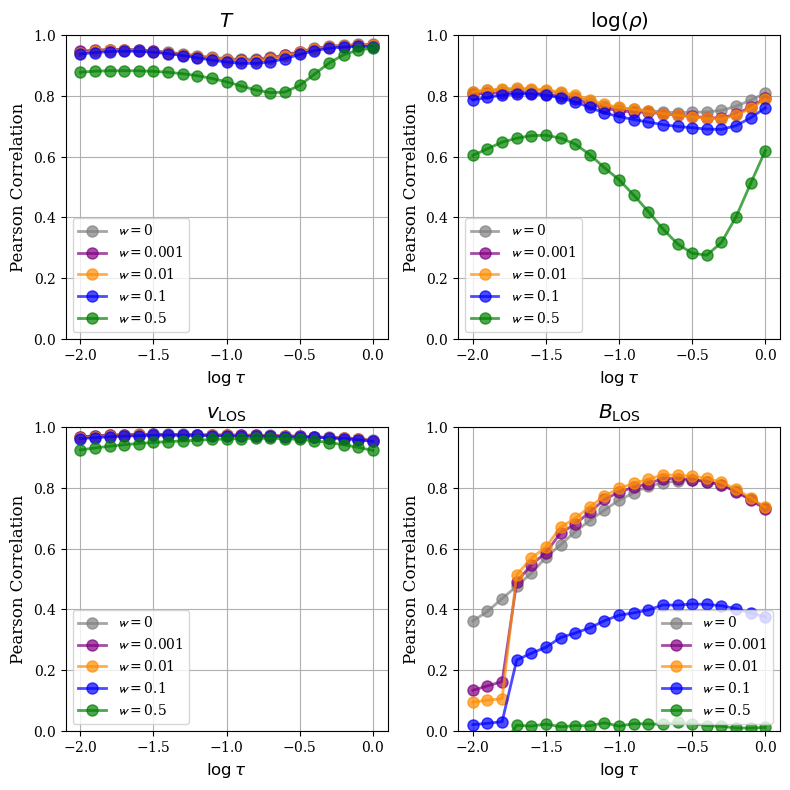

In [21]:
num_params = 4
tau = np.arange(-2.0, 0+0.1, 0.1)

correlations = {}
for key in atm_generated_with_WFA_muram.keys():
    correlations[key] = np.zeros((len(tau), num_params))
    for i, tau_value in enumerate(tau):
        for j in range(num_params):
            gen_values = atm_generated_with_WFA_muram[key][:, :, i, j].flatten()
            orig_values = atm_data_original_muram[:, :, i, j].flatten()
            correlations[key][i, j] = pearsonr(gen_values, orig_values)[0]

fig, axs = plt.subplots(2, 2, figsize=(4*2, 4*2))
axs = axs.flatten()  # Flatten to make indexing easier
titles = [r"$T$", r"$\log(\rho)$", r"$v_{\text{LOS}}$", r"$B_\text{LOS}$"]
colors = ["gray", "purple", "darkorange", "blue", "green"]

for i, key in enumerate(correlations.keys()):
    correlation_data = correlations[key]
    for j in range(num_params):
        axs[j].plot(tau, correlation_data[:, j], marker='o', label=r"$\mathcal{w} = $"+f"{wfa_weigths[i]}", alpha = 0.7, color=colors[i])
        axs[j].set_title(titles[j])
        axs[j].set_xlabel(r'$\log \tau$')
        axs[j].set_ylabel('Pearson Correlation')
        axs[j].grid(True)
        axs[j].set_ylim(0, 1)
        axs[j].legend()

plt.tight_layout()
fig.savefig(images_path / f"MURaM_correlation_{filenames[0]}_epochs_with_wfa.png", dpi=300)
plt.show()

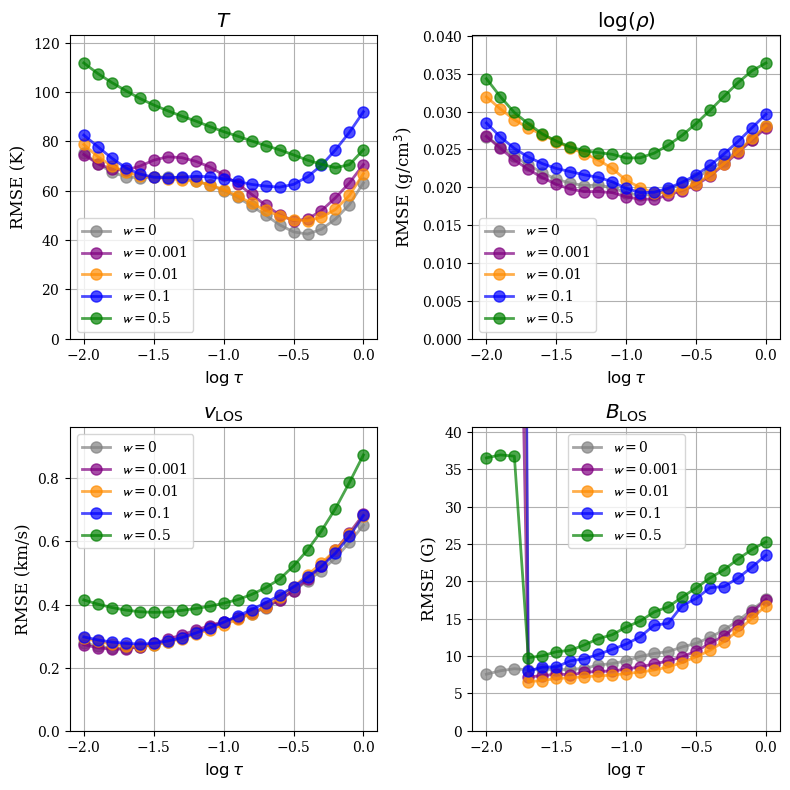

In [22]:
num_params = 4
tau = np.arange(-2.0, 0+0.1, 0.1)

# Calculate RMSE instead of correlation
rmse_values = {}
for key in atm_generated_with_WFA_muram.keys():
    rmse_values[key] = np.zeros((len(tau), num_params))
    for i, tau_value in enumerate(tau):
        for j in range(num_params):
            gen_values = atm_generated_with_WFA_muram[key][:, :, i, j].flatten()
            orig_values = atm_data_original_muram[:, :, i, j].flatten()
            rmse_values[key][i, j] = rmse(gen_values, orig_values)

# Create similar plot but for RMSE
fig, axs = plt.subplots(2, 2, figsize=(4*2, 4*2))
axs = axs.flatten()  # Flatten to make indexing easier
units = ['K', r'g/cm$^3$', 'km/s', 'G']

for i, key in enumerate(rmse_values.keys()):
    rmse_data = rmse_values[key]
    for j in range(num_params):
        axs[j].plot(tau, rmse_data[:, j], marker='o', label=r"$\mathcal{w} = $"+f"{wfa_weigths[i]}", alpha=0.7, color=colors[i])
        axs[j].set_title(titles[j])
        axs[j].set_xlabel(r'$\log \tau$')
        axs[j].set_ylabel(f'RMSE ({units[j]})')
        axs[j].grid(True)
        axs[j].set_ylim(0, np.max(rmse_data[:, j]) * 1.1)  # Set y-axis limits to [0, max_rmse * 1.1]
        # Not setting ylim here as RMSE values can vary widely
        axs[j].legend()

plt.tight_layout()
fig.savefig(images_path / f"MURaM_rmse_{filenames[0]}_epochs_with_wfa.png", dpi=300)
plt.show()

For an example, we will make the surface plot for $\log \tau = -0.8$ for $w = 0.01$.

In [23]:
# Set the index for optical depth tau = -0.8
tau_index = 12

# Get the physical quantities at this tau level
original_data = atm_data_original_muram[:, :, tau_index, :]
wfa_weight_to_plot = 0.01
generated_data = atm_generated_with_WFA_muram[f'wfa weight {wfa_weight_to_plot}'][:, :, tau_index, :]

# Calculate RMSE for each parameter
rmses = []
for param in range(4):
    rmse_val = rmse(original_data[:, :, param].flatten(), generated_data[:, :, param].flatten())
    rmses.append(rmse_val)

# Create figure with subplots
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

# Define titles and units for each parameter

colormaps = ['hot', 'summer', 'RdBu', 'PiYG']
# Plot each parameter
for param in range(4):
    # Get data ranges for consistent colorbar across rows
    vmin = min(np.percentile(original_data[:, :, param], 1),
               np.percentile(generated_data[:, :, param], 1))
    
    vmax = max(np.percentile(original_data[:, :, param], 99), 
               np.percentile(generated_data[:, :, param], 99))
    
    # For velocity and magnetic field, make symmetric colorbar around zero
    if param >= 2:
        abs_max = max(abs(vmin), abs(vmax))
        vmin, vmax = -abs_max, abs_max
    
    cmap = colormaps[param]
    # Plot original data
    im1 = axes[0, param].imshow(original_data[:, :, param], 
                              cmap=cmap, 
                              norm=Normalize(vmin=vmin, vmax=vmax))
    axes[0, param].set_title(f"Original {titles[param]}")
    axes[0, param].set_xticks([])
    axes[0, param].set_yticks([])
    
    # Create colorbar for original data using make_axes_locatable
    divider1 = make_axes_locatable(axes[0, param])
    cax1 = divider1.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(im1, cax=cax1)
    cbar.set_label(units[param])
    
    # Plot generated data with RMSE
    im2 = axes[1, param].imshow(generated_data[:, :, param], 
                              cmap=cmap, 
                              norm=Normalize(vmin=vmin, vmax=vmax))
    axes[1, param].set_title(f"Generated {titles[param]}\nRMSE: {rmses[param]:.3f}")
    axes[1, param].set_xticks([])
    axes[1, param].set_yticks([])
    
    # Create colorbar for generated data using make_axes_locatable
    divider2 = make_axes_locatable(axes[1, param])
    cax2 = divider2.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(im2, cax=cax2)
    cbar.set_label(units[param])

# Set a title for the whole figure
fig.suptitle(f"WFA weight = {wfa_weight_to_plot}", fontsize=16, y=0.98)

plt.tight_layout()
fig.subplots_adjust(top=0.9)
plt.savefig(images_path / f"comparison_original_vs_generated_wfa_{wfa_weight_to_plot}_muram.png", dpi=300, bbox_inches='tight')
plt.show()

## 4. Application on observational data

### 4.1 Charge the observational data

Let's charge the data corresponding to an specific active region that belongs to the MODEST catalog. This data will contain the image in the continuum, the observed original stokes, the expanded stokes (processed and clean), and the corresponded inverted magnitudes with SPINOR on the optical depth nodes $\log \tau = -2.0, -0.8, 0$.

In [24]:
with fits.open("../../data/hinode-MODEST/INV_560_AR11967/continuum.fits") as hdul:
    continuun = hdul[0].data
    cont_header = hdul[0].header
with fits.open("../../data/hinode-MODEST/INV_560_AR11967/inverted_obs.1.fits") as hdul:
    obs_stokes = hdul[0].data
    obs_stokes_header = hdul[0].header
with fits.open("../../data/hinode-MODEST/INV_560_AR11967/inverted_profs.1.fits") as hdul:
    inverted_profs = hdul[0].data
    invprofs_header = hdul[0].header
with fits.open("../../data/hinode-MODEST/INV_560_AR11967/inverted_atmos.fits") as hdul:
    inverted_atm = hdul[0].data
    invatm_header = hdul[0].header

In [25]:
invatm_header

SIMPLE  =                    T / Written by IDL:  Wed May 12 02:56:32 2021      
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    3 / number of data axes                            
NAXIS1  =                  858 / Number of positions along axis 1               
NAXIS2  =                  390 / Number of positions along axis 2               
NAXIS3  =                   23 / Number of positions along axis 3               
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
CODE    = 'SPINOR  '           / inversion code                                 
LTTOP   =                    1 /       0.00      0.00   0 1   0                 
LTINC   =                    2 /       0.00      0.00   0 1   0                 
LGTRF   =                   

For each optical depth node we will obtain the corresponding temperature, magnetic field and velocity in the line-of-sight values

In [26]:
inverted_atm_B_LOS = {}
inverted_atm_T = {}
inverted_atm_V_LOS = {}

modest_tau = np.array([-0.8, 0.0, -2.0])
for i, tau in enumerate(modest_tau):
    # Find the index of the closest value in the array
    index = (np.abs(inverted_atm[0] - tau)).argmin()
    inverted_atm_B_LOS[tau] = np.multiply(inverted_atm[9+i], np.cos(np.deg2rad(inverted_atm[12+i])))
    inverted_atm_T[tau] = inverted_atm[6+i]
    inverted_atm_V_LOS[tau] = inverted_atm[18+i]

Let's define the Hinode wavelength points for the observed stokes and for the expanded stokes

In [27]:
###########################################################
# Observed Stokes profilest
###########################################################

# Parameters from Hinode/SP FITS header (typical values)
NAXIS1 = 112
CRVAL1 = 6302.0    # Ångstroms
CDELT1 = 0.0215    # Å/pixel
CRPIX1 = 57        # Reference pixel

# Wavelength array calculation
wl = CRVAL1 + (np.arange(1, NAXIS1 + 1) - CRPIX1) * CDELT1
wl = wl * u.Angstrom

############################################################
# Expanded stokes profiles
############################################################

center_wavelength = invprofs_header['WLREF']
left_wavelength = center_wavelength + invprofs_header['WLMIN']
right_wavelength = center_wavelength + invprofs_header['WLMAX']
expanded_wl = np.linspace(left_wavelength, right_wavelength, invprofs_header['NWL'])
expanded_wl = expanded_wl * u.Angstrom

Now, we will select the quiet-sun region that we are interested in for doing the comparisons

In [28]:
# Define region boundaries as variables for easy modification
y_start, y_end = 0, 100
x_start, x_end = 500, 700
NX = x_end - x_start
NY = y_end - y_start

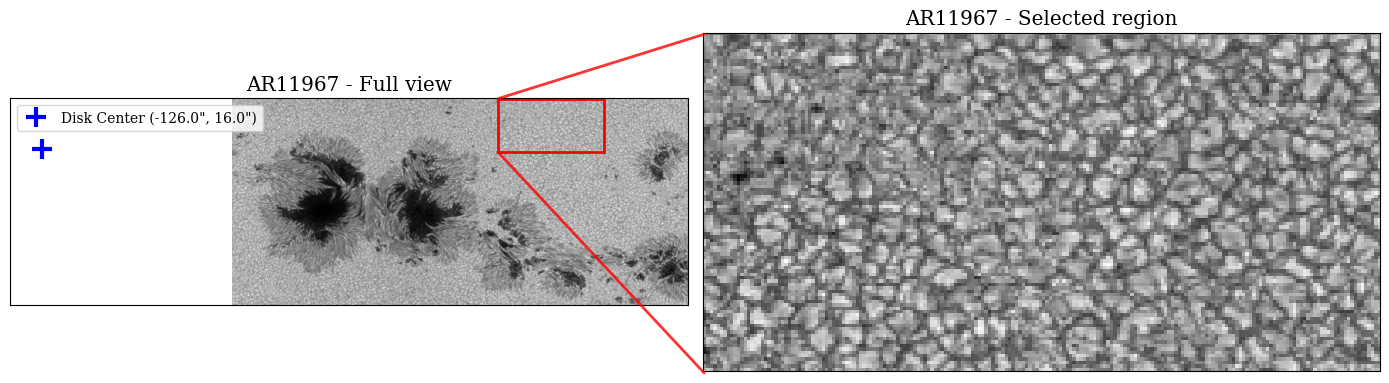

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Solar disk center coordinates in arcseconds
y_center_arcsec = 16.0  # arcseconds
x_center_arcsec = -126.0  # arcseconds

# Convert arcseconds to pixel coordinates (you'll need the pixel scale)
# Typical Hinode/SP pixel scale is ~0.16 arcsec/pixel
pixel_scale = 0.16  # arcsec/pixel (adjust based on your data)
x_center_pixel = x_center_arcsec / pixel_scale + continuun.shape[1] / 2
y_center_pixel = -y_center_arcsec / pixel_scale + continuun.shape[0] / 2

# Plot full image in first subplot with red rectangle and disk center
ax1.imshow(continuun, cmap='gray')
rect = plt.Rectangle((x_start, y_start), x_end-x_start, y_end-y_start, 
                     linewidth=2, edgecolor='r', facecolor='none')
ax1.add_patch(rect)

# Mark the solar disk center
ax1.plot(x_center_pixel, y_center_pixel, 'b+', markersize=15, markeredgewidth=3, 
         label=f'Disk Center ({x_center_arcsec}", {y_center_arcsec}")')
ax1.legend()

ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title("AR11967 - Full view")

# Plot zoomed region in second subplot
ax2.imshow(continuun[y_start:y_end, x_start:x_end], cmap='gray')
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title("AR11967 - Selected region")

# Add connecting lines between the plots
con1 = ConnectionPatch(
    xyA=(0, 0), coordsA=ax2.transData,
    xyB=(x_start, y_start), coordsB=ax1.transData,
    color='r', linestyle='-', linewidth=2.0, alpha=0.8)

con2 = ConnectionPatch(
    xyA=(0, y_end-y_start), coordsA=ax2.transData,
    xyB=(x_start, y_end), coordsB=ax1.transData,
    color='r', linestyle='-', linewidth=2.0, alpha=0.8)

fig.add_artist(con1)
fig.add_artist(con2)

plt.tight_layout()

# Create directory if it doesn't exist
images_dir = Path("../images/fifth_experiment/PhysicsInformed/Hinode_MODEST/")
if not images_dir.exists():
    images_dir.mkdir(parents=True)

fig.savefig(images_dir / "continuum_with_zoom_and_center.png", dpi=300, bbox_inches='tight')

In [30]:
region_BLOS = {}
region_T = {}
region_VLOS = {}

for i, tau in enumerate(modest_tau):
    region_BLOS[tau] = inverted_atm_B_LOS[tau][y_start:y_end, x_start:x_end]
    region_T[tau] = inverted_atm_T[tau][y_start:y_end, x_start:x_end]
    region_VLOS[tau] = inverted_atm_V_LOS[tau][y_start:y_end, x_start:x_end]

### 4.2 MSE loss

Let's compare the results of applying the not WFA constraint model on the Hinode data. For this we will first calculate the correlation and density distributions. First, let's call the models.

In [31]:
def call_los_model(device:str = "cuda",
                scales:list[int] = [1,2,4],
                wfa_weight: float = 0.0,
                base_loss_threshold: float = 0.0004,
                new_logtau = np.arange(-2.0, 0+0.1, 0.1),
                epochs: int = None
                ):
    los_model = InversionModel(scales=scales, 
                                nwl_points=NAXIS1,
                                n_outputs=4*len(new_logtau)).to(device).float()

    los_model.name = "only_LOS"

    base_loss_threshold = 0.0004
    experiment_name = f"Hinode_"+los_model.name+"_WFA_constraint"+f"_wfa_weight_{wfa_weight}_base_loss_threshold_{base_loss_threshold}"
    if epochs is not None:
        experiment_name += f"_epochs_{epochs}"
    weights_name = f"{experiment_name}.pth"

    print(f"Charging weights from {experiment_name}...")

    target_dir = Path("../models/fifth_experiment")      
    charge_weights(model = los_model,
                    target_dir = target_dir,
                    weights_name = weights_name
                )
    
    return los_model

In [32]:
device = "cuda" if torch.cuda.is_available() else "cpu"

wfa_weight = 0
epochs_set = [20,40]
# Create a dictionary to store the models
los_models_not_wfa = {}
# Iterate over the combinations of wfa_weight and epochs
for epochs in epochs_set:
    # Call the function with the current parameters
    model = call_los_model(device=device,
                            wfa_weight=wfa_weight, 
                            base_loss_threshold=0.0004,
                            epochs=epochs)
    # Create a unique key for the model
    key = f"LOS model WFA {wfa_weight} epochs {epochs}"
    # Store the model in the dictionary
    los_models_not_wfa[key] = model

Charging weights from Hinode_only_LOS_WFA_constraint_wfa_weight_0_base_loss_threshold_0.0004_epochs_20...
[INFO] Loading model from: ../models/fifth_experiment/Hinode_only_LOS_WFA_constraint_wfa_weight_0_base_loss_threshold_0.0004_epochs_20.pth
Charging weights from Hinode_only_LOS_WFA_constraint_wfa_weight_0_base_loss_threshold_0.0004_epochs_40...
[INFO] Loading model from: ../models/fifth_experiment/Hinode_only_LOS_WFA_constraint_wfa_weight_0_base_loss_threshold_0.0004_epochs_40.pth


Adapt the Stokes information from the MODEST catalog to match the MSCNN model data processing.

In [33]:
## Putting the required stokes order for the model
reordered_stokes = obs_stokes[:, :, [0,2,3,1], :]
stokes_data_original_modest = reordered_stokes[y_start:y_end, x_start:x_end,:,:].astype(np.float32, copy=True)

In [34]:
# Reshape the data to match the expected input shape
stokes_weights: list[int] = [1,100,100,10]
for i in range(len(stokes_weights)):
    stokes_data_original_modest[:, :, i,:] = stokes_data_original_modest[:, :, i,:] * stokes_weights[i]
stokes_data_original_modest =  np.reshape(np.copy(stokes_data_original_modest), (stokes_data_original_modest.shape[0]*stokes_data_original_modest.shape[1], stokes_data_original_modest.shape[2],stokes_data_original_modest.shape[3]))

Generate the corresponding magnitudes with the MSCNN model for the 21 optical depth points it was trained with.

In [35]:
# Define the new logtau range
new_logtau = np.arange(-2.0, 0+0.1, 0.1)
phys_maxmin = {
            "T": [8e3, 4e3], # K
            "B": [2e3, -2e3], # G
            "Rho": [-7, -6], # g/cm^3 log 
            "V": [1e6, -1e6], #cm/s
        }
atm_generated_not_WFA_modest = {}
# Iterate over the models and generate results
for key, model in los_models_not_wfa.items():
    print(f"Generating results for {key}...")
    atm_generated_not_WFA_modest[key], _ = measure_time(generate_results, model=model,
                                          stokes_data = stokes_data_original_modest,
                                          atm_shape=(NY,NX,new_logtau.shape[0],4),
                                          maxmin = phys_maxmin,
                                          type_of_quantity=1,
                                          device = device
                                        )
# Conversion of units for the velocity from cm/s to km/s
for key in atm_generated_not_WFA_modest.keys():
    atm_generated_not_WFA_modest[key][:, :, :, 2] = atm_generated_not_WFA_modest[key][:, :, :, 2] / 1e5

Generating results for LOS model WFA 0 epochs 20...
stokes data shape for generation: torch.Size([20000, 4, 112])
atm generated data shape : (100, 200, 21, 4)
Elapsed time: 0.2462 seconds
Generating results for LOS model WFA 0 epochs 40...
stokes data shape for generation: torch.Size([20000, 4, 112])
atm generated data shape : (100, 200, 21, 4)
Elapsed time: 0.1993 seconds


Now, we will compare each of the corresponding nodes using the RMSE and correlation metrics.

In [36]:
modest_rmse_not_wfa = {}
modest_correlation_not_wfa = {}

matching_itaus = [12,-1,0]
for key in atm_generated_not_WFA_modest.keys():
    modest_rmse_not_wfa[key] = {}
    modest_correlation_not_wfa[key] = {}
    for i, tau in enumerate(modest_tau):
        # Find the index of the closest value in the array
        index = (np.abs(new_logtau - tau)).argmin()
        # Calculate RMSE
        rmse_T = rmse(atm_generated_not_WFA_modest[key][:, :, index, 0], region_T[tau])
        rmse_VLOS = rmse(atm_generated_not_WFA_modest[key][:, :, index, 2], region_VLOS[tau])
        rmse_BLOS = rmse(atm_generated_not_WFA_modest[key][:, :, index, 3] ,region_BLOS[tau])
        modest_rmse_not_wfa[key][tau] = [rmse_T, rmse_VLOS,rmse_BLOS]
        
        # Calculate correlation
        modest_correlation_not_wfa[key][tau] = [pearsonr(atm_generated_not_WFA_modest[key][:, :, index, 0].flatten(), region_T[tau].flatten())[0],
                                                pearsonr(atm_generated_not_WFA_modest[key][:, :, index, 2].flatten(), region_VLOS[tau].flatten())[0],
                                                pearsonr(atm_generated_not_WFA_modest[key][:, :, index, 3].flatten(), region_BLOS[tau].flatten())[0]]



In [37]:
fig, axs = plt.subplots(1, 3, figsize=(4.5*3, 4))
axs = axs.flatten()  # Flatten to make indexing easier
titles = [r"$T$", r"$v_{\text{LOS}}$", r"$B_\text{LOS}$"]
units = ['K', 'km/s', 'G']
colors = ["purple", "darkorange"]
for i, key in enumerate(modest_rmse_not_wfa.keys()):
    rmse_data = modest_rmse_not_wfa[key]
    for j in range(3):
        axs[j].plot(modest_tau, [rmse_data[tau][j] for tau in modest_tau], marker='o', label=f"{epochs_set[i]}", alpha = 0.7, color=colors[i])
        axs[j].set_title(titles[j])
        axs[j].set_xlabel(r'$\log \tau$')
        axs[j].set_ylabel(f'RMSE ({units[j]})')
        axs[j].set_ylim(0, np.max([rmse_data[tau][j] for tau in modest_tau]) * 1.1)  # Set y-axis limits to [0, max_rmse * 1.1]
        axs[j].grid(True)
        axs[j].legend()

plt.tight_layout()
fig.savefig(images_path / f"MURaM_rmse_Hinode_MODEST_epochs.png", dpi=300)

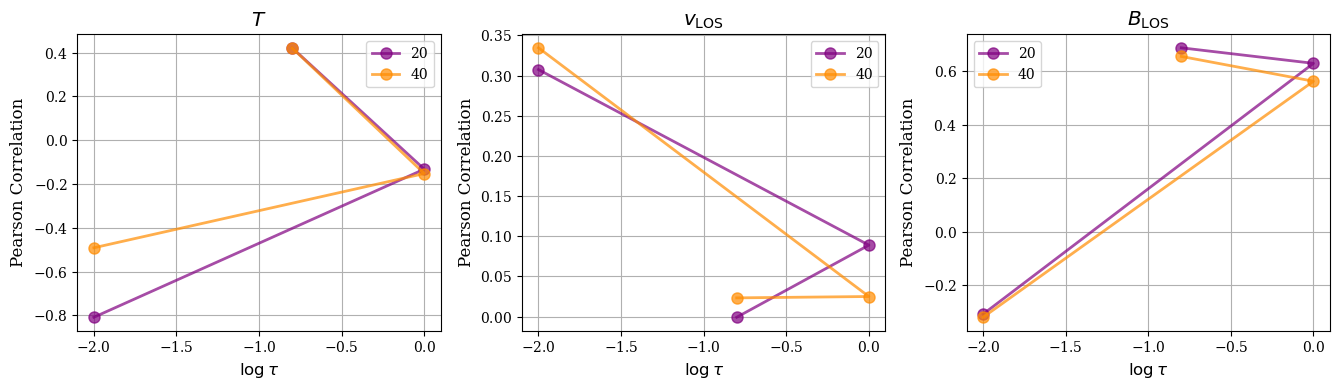

In [38]:
fig, axs = plt.subplots(1, 3, figsize=(4.5*3, 4))
axs = axs.flatten()  # Flatten to make indexing easier
titles = [r"$T$", r"$v_{\text{LOS}}$", r"$B_\text{LOS}$"]
colors = ["purple", "darkorange"]
for i, key in enumerate(modest_rmse_not_wfa.keys()):
    corr_data = modest_correlation_not_wfa[key]
    for j in range(3):
        axs[j].plot(modest_tau, [corr_data[tau][j] for tau in modest_tau], marker='o', label=f"{epochs_set[i]}", alpha = 0.7, color=colors[i])
        axs[j].set_title(titles[j])
        axs[j].set_xlabel(r'$\log \tau$')
        axs[j].set_ylabel('Pearson Correlation')
        axs[j].grid(True)
        axs[j].legend()

plt.tight_layout()
fig.savefig(images_path / f"MURaM_correlation_Hinode_MODEST_epochs.png", dpi=300)

Let's check the apperance of the $B_\text{LOS}$ at $\log \tau = -0.8$

In [39]:
# Plot surface comparison of BLOS at log tau = -0.8
# First, get the BLOS data from MODEST at log tau = -0.8
test_tau = -0
modest_blos = region_BLOS[test_tau]

# Get the corresponding data from the model (40 epochs)
model_not_WFA_key = "LOS model WFA 0 epochs 40"
# Find the index in the model's logtau that corresponds to -0.8
model_not_WFA_index = (np.abs(new_logtau - (test_tau))).argmin()
model_not_WFA_blos = atm_generated_not_WFA_modest[model_not_WFA_key][:, :, model_not_WFA_index, 3]

# Find the range for symmetric colorbar using quantiles of MODEST data
vmin = np.percentile(modest_blos, 5)
vmax = np.percentile(modest_blos, 95)
# Make the colorbar symmetric around 0
abs_max = max(abs(vmin), abs(vmax))
vmin, vmax = -abs_max, abs_max

# Create the figure
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Add the title with less padding
# fig.suptitle(r"$B_\text{LOS}$ at $\log \tau = -0.8$", y=0.9)

rmse_modest_not_wfa = rmse(modest_blos.flatten(), model_not_WFA_blos.flatten())
# Plot MODEST data
im0 = axes[0].imshow(modest_blos, cmap='PiYG', 
                    norm=Normalize(vmin=vmin, vmax=vmax), 
                    interpolation='nearest')
axes[0].set_title("MODEST")

# Plot model generated data
im1 = axes[1].imshow(model_not_WFA_blos, cmap='PiYG', 
                    norm=Normalize(vmin=vmin, vmax=vmax), 
                    interpolation='nearest')
axes[1].set_title("MSCNN \nRMSE: {:.2f} G".format(rmse_modest_not_wfa))

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

# Add colorbar using make_axes_locatable for better positioning
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="2%", pad=0.05)
cbar = fig.colorbar(im1, cax=cax)
cbar.set_label(r"$B_\text{LOS}$ [G]")

fig.suptitle(r"$\log \tau$"+f" = {test_tau}",y=0.85)
plt.tight_layout()

# Save the figure
plt.savefig(images_path / f"blos_comparison_logtau_{test_tau}_not_wfa.png", dpi=300, bbox_inches='tight')
plt.show()

### 4.3 WFA-constraint loss

Let's be sure we are applying it on the correct range of wavelengths. We are going to be inverting the FeI 6301.5 $\text{\AA}$ absorption line.

In [40]:
start_expanded_wl = 30
end_expanded_wl = 105
pixel_y = 70
pixel_x = 650

In [41]:
fig, ax = plt.subplots(1,3,figsize=(10*2,3))
# Set title for the entire figure

# Ensure non-scientific notation for x-axis ticks
for a in ax:
    a.ticklabel_format(useOffset=False, style='plain', axis='x')
    # Add some padding for the suptitle
    plt.subplots_adjust(top=0.85)

    # First subplot to show the pixel location on continuum image
    ax[0].imshow(continuun, cmap='gray')
    ax[0].plot(pixel_x, pixel_y, 'r+', markersize=10)  # Mark the pixel position with a red cross
    ax[0].set_title('Continuum with pixel location')
    ax[0].set_xticks([])
    ax[0].set_yticks([])

    # Stokes I plot
    ax[1].plot(expanded_wl[start_expanded_wl:end_expanded_wl], inverted_profs[pixel_y, pixel_x,0,start_expanded_wl:end_expanded_wl], color = "black")
    ax[1].set_xlabel('Wavelength [nm]')
    ax[1].set_ylabel('Intensity [arb. units]')
    ax[1].set_title('Stokes I')

    # Stokes V plot
    ax[2].plot(expanded_wl[start_expanded_wl:end_expanded_wl], inverted_profs[pixel_y, pixel_x,1,start_expanded_wl:end_expanded_wl], color = "black")
    ax[2].set_xlabel('Wavelength [nm]')
    ax[2].set_ylabel('Intensity [arb. units]')
    ax[2].set_title('Stokes V')

    ax[1].set_xlim(expanded_wl.value[start_expanded_wl], expanded_wl.value[end_expanded_wl])
    ax[2].set_xlim(expanded_wl.value[start_expanded_wl], expanded_wl.value[end_expanded_wl])
plt.show()

Then, we will apply it on the MODEST data. Specifically, on the expanded stokes.

In [42]:
# Magnetic field from Stokes with weak field approximation
inferred_B_LOS = B_LOS_from_stokes(stokes = inverted_profs, 
                                   ll = expanded_wl, 
                                   start_ll = start_expanded_wl, 
                                   end_ll = end_expanded_wl, 
                                   llambda0 = 6301.5*u.Angstrom, 
                                   g = 1.67,
                                   stokes_v_index = 1)
region_BLOS_WFA = inferred_B_LOS.value[y_start:y_end, x_start:x_end]

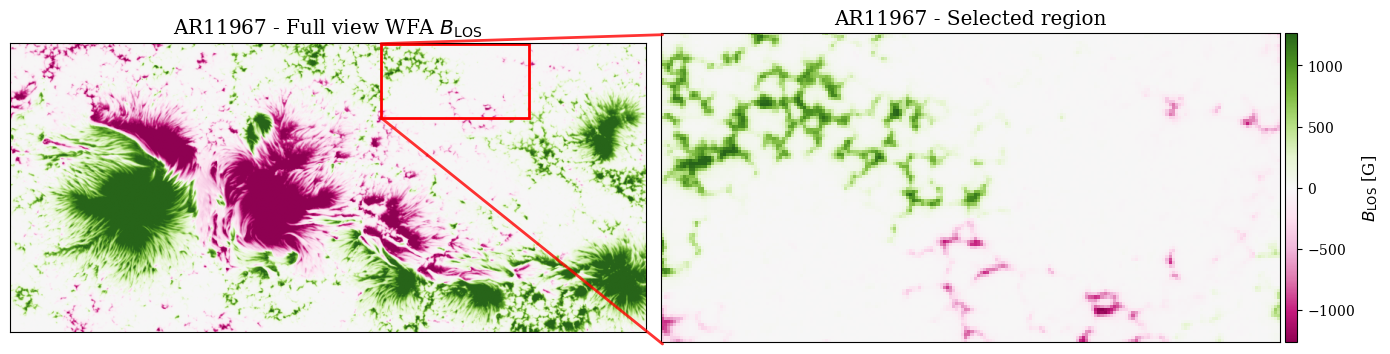

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot full image in first subplot with red rectangle
vmax, vmin = np.percentile(inferred_B_LOS.value, [95, 5])
if np.abs(vmin) > np.abs(vmax):
    vmax = -vmin
else:
    vmin = -vmax

ax1.imshow(inferred_B_LOS.value, cmap='PiYG', vmin=vmin, vmax=vmax)
rect = plt.Rectangle((x_start, y_start), x_end-x_start, y_end-y_start, 
                     linewidth=2, edgecolor='r', facecolor='none')
ax1.add_patch(rect)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title(r"AR11967 - Full view WFA $B_\text{LOS}$")

# Plot zoomed region in second subplot

im = ax2.imshow(region_BLOS_WFA, cmap='PiYG', vmin=vmin, vmax=vmax)
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="2%", pad=0.05)
cbar = fig.colorbar(im, cax=cax)
cbar.set_label(r"$B_\text{LOS}$ [G]")
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title("AR11967 - Selected region")

# Add connecting lines between the plots with increased thickness and opacity
# Use ConnectionPatch to connect the two plots

# Connect bottom-left corners
con1 = ConnectionPatch(
    xyA=(0, 0), coordsA=ax2.transData,
    xyB=(x_start, y_start), coordsB=ax1.transData,
    color='r', linestyle='-', linewidth=2.0, alpha=0.8)

# Connect top-right corners
con2 = ConnectionPatch(
    xyA=(0, y_end-y_start), coordsA=ax2.transData,
    xyB=(x_start, y_end), coordsB=ax1.transData,
    color='r', linestyle='-', linewidth=2.0, alpha=0.8)

fig.add_artist(con1)
fig.add_artist(con2)

plt.tight_layout()

Compared to MODEST data, we have that

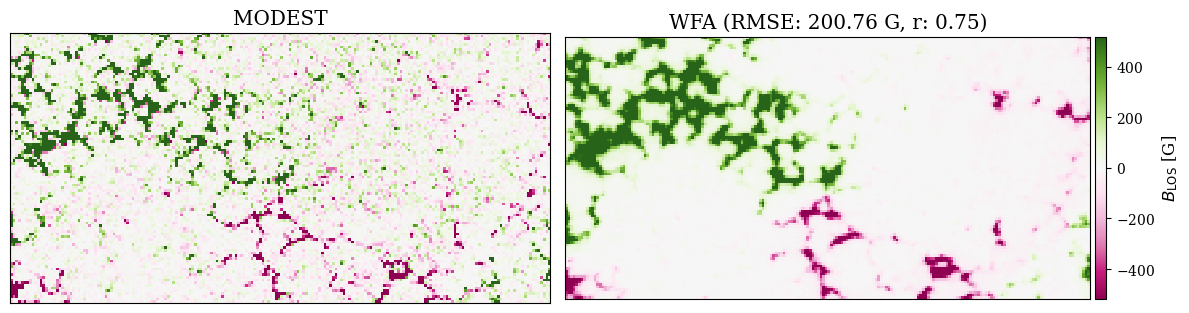

In [44]:
# Calculate RMSE and correlation between the two magnetic field measurements
rmse_value = rmse(modest_blos.flatten(), region_BLOS_WFA.flatten())
corr_value = pearsonr(modest_blos.flatten(), region_BLOS_WFA.flatten())[0]

# Find the range for symmetric colorbar using quantiles of both datasets
vmin1 = np.percentile(modest_blos, 5)
vmax1 = np.percentile(modest_blos, 95)
vmin2 = np.percentile(region_BLOS_WFA, 5)
vmax2 = np.percentile(region_BLOS_WFA, 95)
abs_max = max(abs(vmin1), abs(vmax1), abs(vmin2), abs(vmax2))
vmin, vmax = -abs_max, abs_max

# Create the figure
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot MODEST data
im0 = axes[0].imshow(modest_blos, cmap='PiYG', 
                    norm=Normalize(vmin=vmin, vmax=vmax), 
                    interpolation='nearest')
axes[0].set_title("MODEST")

# Plot WFA data with RMSE and correlation in title
im1 = axes[1].imshow(region_BLOS_WFA, cmap='PiYG', 
                    norm=Normalize(vmin=vmin, vmax=vmax), 
                    interpolation='nearest')
axes[1].set_title(f"WFA (RMSE: {rmse_value:.2f} G, r: {corr_value:.2f})")

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

# Add colorbar using make_axes_locatable for better positioning
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="2%", pad=0.05)
cbar = fig.colorbar(im1, cax=cax)
cbar.set_label(r"$B_\text{LOS}$ [G]")

plt.tight_layout()

# Save the figure
plt.savefig(images_path / "modest_vs_wfa_blos_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

For the four weight values tested $w = 0.001, 0.01, 0.1, 0.5$ we have the following correlation and RMSE values compared to MODEST.

In [45]:


atm_generated_with_WFA_modest = {}
# Iterate over the models and generate results
for key, model in los_models_with_WFA.items():
    print(f"Generating results for {key}...")
    atm_generated_with_WFA_modest[key], _ = measure_time(generate_results, model=model,
                                          stokes_data = stokes_data_original_modest,
                                          atm_shape=(NY,NX,new_logtau.shape[0],4),
                                          maxmin = phys_maxmin,
                                          type_of_quantity=1,
                                          device = device
                                        )
# Conversion of units for the velocity from cm/s to km/s
for key in atm_generated_with_WFA_modest.keys():
    atm_generated_with_WFA_modest[key][:, :, :, 2] = atm_generated_with_WFA_modest[key][:, :, :, 2] / 1e5

Generating results for wfa weight 0...
stokes data shape for generation: torch.Size([20000, 4, 112])
atm generated data shape : (100, 200, 21, 4)
Elapsed time: 0.1931 seconds
Generating results for wfa weight 0.001...
stokes data shape for generation: torch.Size([20000, 4, 112])
atm generated data shape : (100, 200, 21, 4)
Elapsed time: 0.2017 seconds
Generating results for wfa weight 0.01...
stokes data shape for generation: torch.Size([20000, 4, 112])
atm generated data shape : (100, 200, 21, 4)
Elapsed time: 0.1983 seconds
Generating results for wfa weight 0.1...
stokes data shape for generation: torch.Size([20000, 4, 112])
atm generated data shape : (100, 200, 21, 4)
Elapsed time: 0.2023 seconds
Generating results for wfa weight 0.5...
stokes data shape for generation: torch.Size([20000, 4, 112])
atm generated data shape : (100, 200, 21, 4)
Elapsed time: 0.2151 seconds


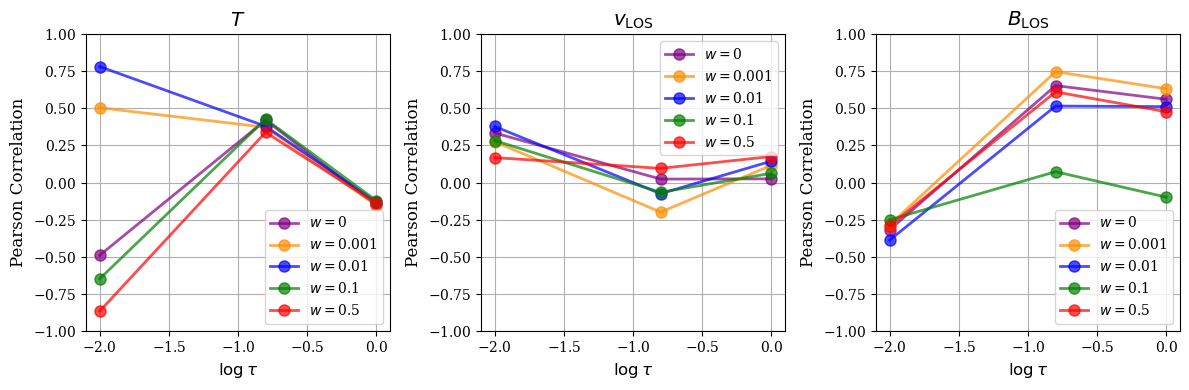

In [46]:
# Calculate correlations between MODEST data and neural network models with different WFA weights
wfa_weights = [0, 0.001, 0.01, 0.1, 0.5]
modest_tau = np.array([0.0, -0.8, -2.0])
num_params = 3  # T, vLOS, BLOS
param_indices = [0, 2, 3]  # Indices in the NN model output corresponding to T, vLOS, BLOS

# First handle the models without WFA constraint (already calculated)
correlations = {}
for key in atm_generated_with_WFA_modest.keys():
    correlations[key] = np.zeros((len(modest_tau), num_params))
    for i, tau_value in enumerate(modest_tau):
        nn_tau_index = (np.abs(new_logtau - tau_value)).argmin()
        
        for j, param_idx in enumerate(param_indices):
            if j == 0:  # Temperature
                nn_values = atm_generated_with_WFA_modest[key][:, :, nn_tau_index, param_idx].flatten()
                modest_values = region_T[tau_value].flatten()
            elif j == 1:  # Velocity
                nn_values = atm_generated_with_WFA_modest[key][:, :, nn_tau_index, param_idx].flatten()
                modest_values = region_VLOS[tau_value].flatten()
            elif j == 2:  # Magnetic field
                nn_values = atm_generated_with_WFA_modest[key][:, :, nn_tau_index, param_idx].flatten()
                modest_values = region_BLOS[tau_value].flatten()
            
            correlations[key][i, j] = pearsonr(nn_values, modest_values)[0]

# Create the correlation plot
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
titles = [r"$T$", r"$v_{\text{LOS}}$", r"$B_\text{LOS}$"]
colors = ["purple", "darkorange", "blue", "green", "red", "gray"]

for i, key in enumerate(correlations.keys()):
    correlation_data = correlations[key]
    for j in range(num_params):
        axs[j].plot(modest_tau, correlation_data[:, j], marker='o', label=r"$w=$"+f"{wfa_weights[i]}", alpha=0.7, color=colors[i])
        axs[j].set_title(titles[j])
        axs[j].set_xlabel(r'$\log \tau$')
        axs[j].set_ylabel('Pearson Correlation')
        axs[j].grid(True)
        axs[j].set_ylim(-1, 1)
        axs[j].legend()

plt.tight_layout()
fig.savefig(images_path / "MODEST_correlation_comparison.png", dpi=300)
plt.show()

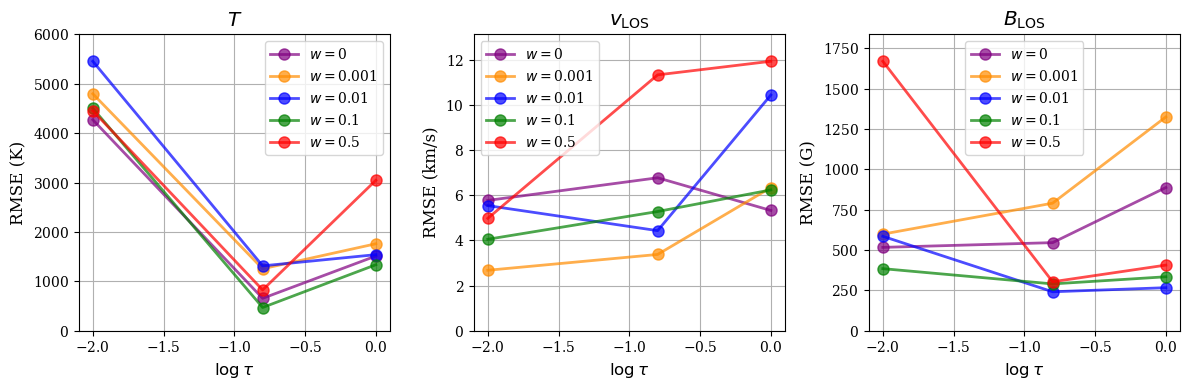

In [47]:
# Calculate RMSE between MODEST data and neural network models with different WFA weights
wfa_weights = [0, 0.001, 0.01, 0.1, 0.5]
modest_tau = np.array([0.0, -0.8, -2.0])
num_params = 3  # T, vLOS, BLOS
param_indices = [0, 2, 3]  # Indices in the NN model output corresponding to T, vLOS, BLOS

# Create dictionary to store RMSE values
rmse_values = {}
for key in atm_generated_with_WFA_modest.keys():
    rmse_values[key] = np.zeros((len(modest_tau), num_params))
    for i, tau_value in enumerate(modest_tau):
        nn_tau_index = (np.abs(new_logtau - tau_value)).argmin()
        
        for j, param_idx in enumerate(param_indices):
            if j == 0:  # Temperature
                nn_values = atm_generated_with_WFA_modest[key][:, :, nn_tau_index, param_idx].flatten()
                modest_values = region_T[tau_value].flatten()
            elif j == 1:  # Velocity
                nn_values = atm_generated_with_WFA_modest[key][:, :, nn_tau_index, param_idx].flatten()
                modest_values = region_VLOS[tau_value].flatten()
            elif j == 2:  # Magnetic field
                nn_values = atm_generated_with_WFA_modest[key][:, :, nn_tau_index, param_idx].flatten()
                modest_values = region_BLOS[tau_value].flatten()
            
            rmse_values[key][i, j] = rmse(nn_values, modest_values)

# Create the RMSE plot
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
colors = ["purple", "darkorange", "blue", "green", "red"]

for i, key in enumerate(rmse_values.keys()):
    rmse_data = rmse_values[key]
    for j in range(num_params):
        axs[j].plot(modest_tau, rmse_data[:, j], marker='o', label=r"$w=$"+f"{wfa_weights[i]}", alpha=0.7, color=colors[i])
        axs[j].set_title(titles[j])
        axs[j].set_xlabel(r'$\log \tau$')
        axs[j].set_ylabel(f'RMSE ({units[j]})')
        axs[j].grid(True)
        axs[j].set_ylim(bottom=0)
        axs[j].legend()

# Adjust each subplot's y-axis limit to show all data with some headroom
for j in range(num_params):
    all_values = np.array([rmse_values[key][:, j] for key in rmse_values.keys()]).flatten()
    max_val = np.max(all_values)
    axs[j].set_ylim(top=max_val*1.1)  # Add 10% headroom

plt.tight_layout()
fig.savefig(images_path / "MODEST_rmse_comparison.png", dpi=300)
plt.show()

Let's plot the corresponding surfaces for the three parameters comparing the MODEST data to the NN inversion results.

In [48]:
# Define the variables for easier testing
optical_depth_value = -0
wfa_weight_for_testing = 0

In [49]:
# Get MODEST data at optical depth
modest_T = region_T[optical_depth_value]
modest_vlos = region_VLOS[optical_depth_value]
modest_blos = region_BLOS[optical_depth_value]

# Find the index in the model's logtau that corresponds to the optical depth
model_tau_index = (np.abs(new_logtau - (optical_depth_value))).argmin()

# Get the corresponding data from the model with the WFA weight
model_T = atm_generated_with_WFA_modest[f"wfa weight {wfa_weight_for_testing}"][:, :, model_tau_index, 0]
model_vlos = atm_generated_with_WFA_modest[f"wfa weight {wfa_weight_for_testing}"][:, :, model_tau_index, 2]
model_blos = atm_generated_with_WFA_modest[f"wfa weight {wfa_weight_for_testing}"][:, :, model_tau_index, 3]

# Define parameters for each physical quantity
quantities = [
    {"name": "T", "modest": modest_T, "model": model_T, "cmap": "hot", "label": "Temperature [K]"},
    {"name": "v_LOS", "modest": modest_vlos, "model": model_vlos, "cmap": "RdBu", "label": "LOS Velocity [km/s]"},
    {"name": "B_LOS", "modest": modest_blos, "model": model_blos, "cmap": "PiYG", "label": r"$B_\text{LOS}$ [G]", "unit": "G"}
]

# Create a figure with three rows (one for each quantity)
fig, all_axes = plt.subplots(1, 2, figsize=(2*7, 4))

# Process each quantity
for i, q in enumerate(quantities):
    # Calculate RMSE and correlation
    rmse_value = rmse(q["modest"].flatten(), q["model"].flatten())
    corr_value = pearsonr(q["modest"].flatten(), q["model"].flatten())[0]
    
    # Get min/max for colorbar (for symmetric scales on velocity and B field)
    vmin = np.percentile(q["modest"], 5)
    vmax = np.percentile(q["modest"], 95)
    
    if q["name"] in ["v_LOS", "B_LOS"]:  # Symmetric colorbar for velocity and magnetic field
        abs_max = max(abs(vmin), abs(vmax))
        vmin, vmax = -abs_max, abs_max
    
    axes = all_axes
    
    # Plot MODEST data
    im0 = axes[0].imshow(q["modest"], cmap=q["cmap"], 
                        norm=Normalize(vmin=vmin, vmax=vmax), 
                        interpolation='nearest')
    axes[0].set_title(f"MODEST")
    
    # Plot model data
    im1 = axes[1].imshow(q["model"], cmap=q["cmap"], 
                        norm=Normalize(vmin=vmin, vmax=vmax), 
                        interpolation='nearest')
    axes[1].set_title(r"MSCNN ($\mathcal{w}$="+f"{wfa_weight_for_testing})\nRMSE: {rmse_value:.2f} {q["unit"]} r: {corr_value:.2f}")
    
    # Remove ticks
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Add colorbar
    divider = make_axes_locatable(axes[1])
    cax = divider.append_axes("right", size="5%", pad=0.005)
    cbar = fig.colorbar(im1, cax=cax)
    cbar.set_label(q["label"])

plt.suptitle(fr"$\log \tau = {optical_depth_value}$", fontsize=16, y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.savefig(images_path / f"modest_vs_model_comparison_tau{optical_depth_value}_wfa_weight{wfa_weight_for_testing}.png", dpi=300, bbox_inches='tight')
plt.show()

KeyError: 'unit'

In [ ]:
def plot_density_bars_with_MODEST(atm_generated: np.ndarray,
  atm_original: np.ndarray,
  rmse_list: list,
  model_subdir: str,
  dense_diag_subdir: str,
  image_name: str,
  titles: list,
  tau_index: int,
  tau: np.ndarray = np.linspace(-2.5,0,20),
  num_bars: int = None,
  images_dir: str = "images",
  filename: str = None
  ):
  """
  Plots the density of values of the atm_generated and atm_original for a specific optical depth index.
  The plot is composed of bars.

  Args:
  atm_generated (np.ndarray): Generated atmospheric data.
  atm_original (np.ndarray): Original atmospheric data.
  model_subdir (str): Subdirectory for saving the plot.
  image_name (str): Name of the image file.
  titles (list): List of titles for each subplot.
  tau_index (int): Index of the optical depth to plot.
  images_dir (str, optional): Directory to save the images. Defaults to "images".
  num_bars (int, optional): Number of bars in the plot. Defaults to 10.
  """
  
  num_params = atm_generated.shape[3]
  num_rows = num_params  # Calculate the number of rows needed for two columns

  fig, axs = plt.subplots(1, num_rows, figsize=(3.5 * num_rows, 4))
  fig.suptitle(r'$\log \tau$'+f' = {tau[tau_index]:.2f}')
  # Define units for each parameter
  units = ['K', 'km/s', 'G']

  for j in range(num_params):
    gen_values = atm_generated[:, :, tau_index, j].flatten()
    orig_values = atm_original[:, :, tau_index, j].flatten()
    gen_q5, gen_q95 = np.quantile(
       gen_values, [0.05, 0.85])
    orig_q5, orig_q95 = np.quantile(orig_values, [0.05, 0.85])
    xlim_min = min(gen_q5, orig_q5)
    xlim_max = max(gen_q95, orig_q95)

    # Create histogram bins
    if not num_bars:
      gen_q25m, gen_q75m = np.quantile(gen_values, [0.25, 0.75])
      IQR_gen = gen_q75m - gen_q25m
      gen_bin_width = 2 * IQR_gen / (len(gen_values) ** (1 / 3))
      orig_q25m, orig_q75m = np.quantile(orig_values, [0.25, 0.75])
      IQR_orig = orig_q75m - orig_q25m
      orig_bin_width = 2 * IQR_orig / (len(orig_values) ** (1 / 3))
      num_bars = int((max(gen_values.max(), orig_values.max()) - min(gen_values.min(), orig_values.min())) / max(gen_bin_width, orig_bin_width))
      num_bars = min(num_bars, 100)
    
    bins = np.linspace(xlim_min, xlim_max, num_bars + 1)
    rmse = rmse_list[j]
    
    
    # Plot histograms
    axs[j].hist(gen_values, bins=bins, alpha=0.5, label='Generated', color='orangered')
    axs[j].hist(orig_values, bins=bins, alpha=0.5, label='Original', color='navy')
    axs[j].set_title(f"rmse = {rmse:.2f} {units[j]}")
    axs[j].set_xlabel(f'{titles[j]} ({units[j]})')
    axs[j].legend(loc='upper right')
    axs[j].set_xlim([xlim_min, xlim_max])  # Set xlim based on quantiles

  fig.tight_layout()
  plt.show()
  images_dir = os.path.join(images_dir, filename, model_subdir, dense_diag_subdir)
  if not os.path.exists(images_dir):
    os.makedirs(images_dir)
  image_path = os.path.join(images_dir, f"{tau[tau_index]:.2f}_{image_name}")
  fig.savefig(image_path)

  print(f"Saved image to: {image_path}")

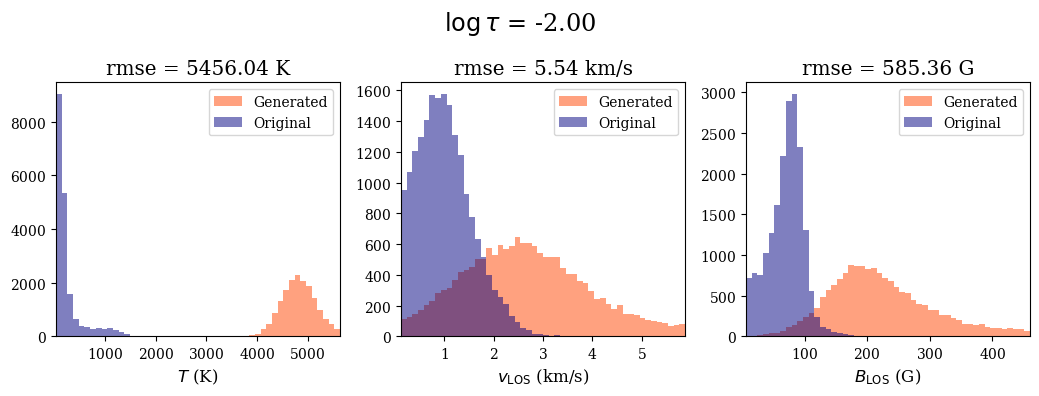

Saved image to: ../thesis_images/fifth_experiment/histogram_analysis/modest_comparison/wfa_weight_0.01/-2.00_histogram_comparison_logtau_wfa_weight_0.01.png


In [ ]:
# Import necessary libraries if not already imported

# Define the optical depth value and index
optical_depth_value = -2.0
model_tau_index = (np.abs(new_logtau - optical_depth_value)).argmin()

# Create 4D arrays with shape (ny, nx, ntau=1, nparams=3) for MODEST and generated data
# We'll use a single tau layer since we're comparing at a specific optical depth
wfa_weight_for_testing = 0.01
# MODEST data (original)
modest_data = np.zeros((NY, NX, 1, 3))
modest_data[:, :, 0, 0] = region_T[optical_depth_value]
modest_data[:, :, 0, 1] = region_VLOS[optical_depth_value]
modest_data[:, :, 0, 2] = region_BLOS[optical_depth_value]

# Generated data from model
model_data = np.zeros((NY, NX, 1, 3))
model_data[:, :, 0, 0] = atm_generated_with_WFA_modest[f"wfa weight {wfa_weight_for_testing}"][:, :, model_tau_index, 0]
model_data[:, :, 0, 1] = atm_generated_with_WFA_modest[f"wfa weight {wfa_weight_for_testing}"][:, :, model_tau_index, 2]
model_data[:, :, 0, 2] = atm_generated_with_WFA_modest[f"wfa weight {wfa_weight_for_testing}"][:, :, model_tau_index, 3]

rmse_list = []
for i in range(3):
    rmse_list.append(rmse(modest_data[:, :, 0, i].flatten(), model_data[:, :, 0, i].flatten()))

# Define plotting parameters
modest_titles = [r"$T$", r"$v_\text{LOS}$", r"$B_\text{LOS}$"]
tau_array = np.array([optical_depth_value])  # Just the one value we're using

# Call the plot_density_bars function
plot_density_bars_with_MODEST(
    atm_generated=model_data,
    atm_original=modest_data,
    rmse_list=rmse_list,
    model_subdir="modest_comparison",
    dense_diag_subdir=f"wfa_weight_{wfa_weight_for_testing}",
    image_name=f"histogram_comparison_logtau_wfa_weight_{wfa_weight_for_testing}.png",
    titles=titles,
    tau_index=0,  # Since we only have one tau value in our arrays
    tau=tau_array,
    num_bars=50,  # Reasonable number of bars for the histogram
    images_dir=str(images_path),
    filename="histogram_analysis"
)



In [ ]:
def plot_scatter_with_MODEST(atm_generated: np.ndarray,
                            atm_original: np.ndarray,
                            rmse_list: list,
                            corr_list: list,
                            model_subdir: str,
                            scatter_subdir: str,
                            image_name: str,
                            titles: list,
                            tau_index: int,
                            tau: np.ndarray = np.linspace(-2.5,0,20),
                            images_dir: str = "images",
                            filename: str = None
                            ):
    """
    Creates scatter plots comparing generated vs original atmospheric data for a specific optical depth index.
    
    Args:
    atm_generated (np.ndarray): Generated atmospheric data.
    atm_original (np.ndarray): Original atmospheric data.
    rmse_list (list): List of RMSE values for each parameter.
    corr_list (list): List of correlation values for each parameter.
    model_subdir (str): Subdirectory for saving the plot.
    scatter_subdir (str): Subdirectory for scatter plots.
    image_name (str): Name of the image file.
    titles (list): List of titles for each subplot.
    tau_index (int): Index of the optical depth to plot.
    tau (np.ndarray, optional): Array of optical depth values.
    images_dir (str, optional): Directory to save the images.
    filename (str, optional): Filename for subdirectory.
    """
    
    num_params = atm_generated.shape[3]
    fig, axs = plt.subplots(1, num_params, figsize=(4 * num_params, 4))
    if num_params == 1:
        axs = [axs]
    
    fig.suptitle(r'$\log \tau$'+f' = {tau[tau_index]:.2f}')
    
    # Define units for each parameter
    units = ['K', 'km/s', 'G']
    
    for j in range(num_params):
        gen_values = atm_generated[:, :, tau_index, j].flatten()
        orig_values = atm_original[:, :, tau_index, j].flatten()
        
        # Create scatter plot with transparency
        axs[j].scatter(orig_values, gen_values, alpha=0.3, s=1, color='navy')
        
        # Add 1:1 line
        min_val = min(orig_values.min(), gen_values.min())
        max_val = max(orig_values.max(), gen_values.max())
        axs[j].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, linewidth=2)
        
        # Set labels and title
        axs[j].set_xlabel(f'MODEST {titles[j]} ({units[j]})')
        axs[j].set_ylabel(f'MSCNN {titles[j]} ({units[j]})')
        axs[j].set_title(f'RMSE = {rmse_list[j]:.2f} {units[j]}\nr = {corr_list[j]:.3f}')
        
        # Set equal aspect ratio and limits
        axs[j].set_aspect('equal')
        axs[j].set_xlim([min_val, max_val])
        axs[j].set_ylim([min_val, max_val])
        
        # Add grid
        axs[j].grid(True, alpha=0.3)
    
    fig.tight_layout()
    plt.show()
    
    # Save the plot
    images_dir = os.path.join(images_dir, filename, model_subdir, scatter_subdir)
    if not os.path.exists(images_dir):
        os.makedirs(images_dir)
    image_path = os.path.join(images_dir, f"{tau[tau_index]:.2f}_{image_name}")
    fig.savefig(image_path, dpi=300, bbox_inches='tight')
    
    print(f"Saved scatter plot to: {image_path}")

# Calculate correlation coefficients for the scatter plot
corr_list = []
for i in range(3):
    corr_val = pearsonr(modest_data[:, :, 0, i].flatten(), model_data[:, :, 0, i].flatten())[0]
    corr_list.append(corr_val)

# Call the scatter plot function
plot_scatter_with_MODEST(
    atm_generated=model_data,
    atm_original=modest_data,
    rmse_list=rmse_list,
    corr_list=corr_list,
    model_subdir="modest_comparison",
    scatter_subdir=f"wfa_weight_{wfa_weight_for_testing}",
    image_name=f"scatter_comparison_logtau_wfa_weight_{wfa_weight_for_testing}.png",
    titles=titles,
    tau_index=0,
    tau=tau_array,
    images_dir=str(images_path),
    filename="scatter_analysis"
)